In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import random

import nltk                         # import NLTK to handle simple NL tasks like tokenization.
nltk.download("punkt")
from nltk.util import ngrams
from collections import Counter     # import the Counter module.
#!pip3 install 'sacrebleu'           # install the sacrebleu package.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.

import statistics

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 61kB 6.2MB/s 


In [3]:
# Global parameters
#root folder
root_folder='/content/drive/MyDrive/machine-translation/'
#data_folder='.'
data_folder_name='corpus/fra-eng'
train_filename='fra.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

In [4]:
train_filenamepath

'/content/drive/MyDrive/machine-translation/corpus/fra-eng/fra.txt'

In [45]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 180000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM=1024 #512

BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 10  # Number of epochs to train for.

ATTENTION_FUNC='general'

In [12]:
#Preprocessing the data
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

In [46]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[TARGET_COLUMN,INPUT_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)

In [47]:
df = df[df['input'].str.split().str.len().lt(15)]
df = df[df['target'].str.split().str.len().lt(15)]
df

,target,input
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.
...,...,...
179995,It was so hot that I thought I was going to pa...,Il faisait si chaud que je pensais que j'allai...
179996,It was so hot that I thought I was going to pa...,Il faisait tellement chaud que je pensais que ...
179997,It was so still that you would have heard a pi...,C'était si calme qu'on aurait entendu tomber u...
179998,It was such a cold day that we decided not to ...,Il faisait tellement froid qu'on a décidé de n...


In [48]:
train, test = train_test_split(df, test_size=0.01)

In [49]:
train

,target,input
155347,Either they don't want to or they can't.,"Soit elles ne le veulent pas, soit elles ne le..."
23692,I truly loved her.,Je l'aimais vraiment.
68088,He promised not to smoke.,Il me promit de ne pas fumer.
146504,There's something else in the drawer.,Il y a autre chose dans le tiroir.
136284,I was told that we have until 2:30.,On m'a dit que nous avions jusqu'à 14 h 30.
...,...,...
110834,Are you listening to me at all?,M'écoutes-tu le moins du monde ?
169459,This happened prior to receiving your letter.,Ceci est survenu avant la réception de ta lettre.
46443,Do you believe it now?,Est-ce que tu le crois maintenant ?
9025,Where are you?,Où êtes-vous ?


In [50]:
test

,target,input
160262,She suggested that I take him to the zoo.,Elle a suggéré que je l'emmène au zoo.
143451,You're kind of cute when you're mad.,Vous êtes assez mignonne quand vous êtes en co...
30209,Let me borrow that.,Laisse-moi emprunter ça.
168698,I think it'd be better if you didn't do that.,Je pense que ce serait mieux que tu ne fasses ...
74882,Don't even think about it.,N'y pense même pas !
...,...,...
94416,The bed is very comfortable.,Le lit est très confortable.
155366,"Excuse me, is there a hotel around here?","Excusez-moi, y a-t-il un hôtel dans le coin ?"
110008,Where did you find this knife?,Où as-tu trouvé ce couteau ?
8120,She is a twin.,C'est une jumelle.


In [51]:
# Preprocess the input data
input_data=train[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=train[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is right shifted
target_input_data=train[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:3])
print(target_data[:3])
print(target_input_data[:3])

['soit elles ne le veulent pas , soit elles ne le peuvent .', 'je l aimais vraiment .', 'il me promit de ne pas fumer .']
['either they don t want to or they can t . <eos>', 'i truly loved her . <eos>', 'he promised not to smoke . <eos>']
['<sos> either they don t want to or they can t .', '<sos> i truly loved her .', '<sos> he promised not to smoke .']


In [52]:
# Create a tokenizer for the input texts(French) and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[19995])
print(input_sequences[19995])

Max Input Length:  20
tom m a montre son album photo .
[15, 39, 3, 353, 73, 2201, 385, 1]


In [53]:
# tokenize the outputs(English)
# don't filter out special characters (filters = '')
# otherwise <sos> and <eos> won't appear
# By default, Keras’ Tokenizer will trim out all the punctuations, which is not what we want. 
# we can just set filters as blank here.

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[19995])
print(target_sequences[19995])
print(target_input_data[19995])
print(target_sequences_inputs[19995])

Max Target Length:  18
tom showed me his photo album . <eos>
[11, 798, 19, 48, 1585, 1900, 1, 2]
<sos> tom showed me his photo album .
[3, 11, 798, 19, 48, 1585, 1900, 1]


In [54]:
#Creating Vocabularies
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 21976 unique input tokens.
Found 13305 unique output tokens.


In [55]:
#Padding - necessary to pad the sentences with 0 at the end so all the sentences have the smae length
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (177891, 20)
encoder_inputs[0]: [138  93  11  13 669   7  23 138  93  11  13 562   1   0   0   0   0   0
   0   0]
decoder_inputs[0]: [  3 724  42  21  10  36   6 222  42  29  10   1   0   0   0   0   0   0]
decoder_inputs.shape: (177891, 18)


In [56]:
#Creating a batch data generator 
#Since we want to train our model in batches we need to create a dataset using tf.data library.
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets))
dataset = dataset.shuffle(len(input_data)).batch(
    BATCH_SIZE, drop_remainder=True)

In [57]:
#Encoder Function
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [58]:
#Attention Class
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError(
                'Attention score must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(rnn_size)
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)

    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True) # (batch_size, 1, max_len)
        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True) #(batch_size, 1, max_len)
        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1]) #shape (batch size, max len,hidden_dim)

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1))) # (batch_size, max len, 1)

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)

        # alignment a_t = softmax(score)
        alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
        
        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output) # (batch_size, 1, hidden_dim)

        return context, alignment

In [59]:
#Creating the Decoder Class
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, attention_func):
        super(Decoder, self).__init__()
        self.attention = LuongAttention(hidden_dim, attention_func)
        self.hidden_dim = hidden_dim
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(input_sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, hidden_dim)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, hidden_dim)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, hidden_dim),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.wc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

In [60]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM, ATTENTION_FUNC)

# Call the encoder and then the decoder
initial_state = encoder.init_states(1)
encoder_outputs = encoder(tf.constant([[1]]), initial_state)
decoder_outputs = decoder(tf.constant(
    [[1]]), encoder_outputs[1:], encoder_outputs[0])

In [61]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [62]:
#Training Function
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    loss = 0.
    acc = 0.
    logits = None
    
    with tf.GradientTape() as tape:
        en_outputs = encoder(input_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states

        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])

            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)
            # Store the logits to calculate the accuracy
            logit = K.expand_dims(logit, axis=1)
            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits,logit), axis=1)
        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits)
    # Update the parameters and the optimizer
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1], acc

In [63]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [64]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/machine-translation/models/fra-eng/training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 4.2617 Acc:0.0000
Epoch 1 Batch 100 Loss 2.2050 Acc:0.2635
Epoch 1 Batch 200 Loss 1.9616 Acc:0.3162
Epoch 1 Batch 300 Loss 1.8466 Acc:0.3491
Epoch 1 Batch 400 Loss 1.5986 Acc:0.3865
Epoch 1 Batch 500 Loss 1.7103 Acc:0.3962
Epoch 1 Batch 600 Loss 1.4990 Acc:0.4521
Epoch 1 Batch 700 Loss 1.5030 Acc:0.4150
Epoch 1 Batch 800 Loss 1.3984 Acc:0.4602
Epoch 1 Batch 900 Loss 1.3305 Acc:0.5010
Epoch 1 Batch 1000 Loss 1.4972 Acc:0.4640
Epoch 1 Batch 1100 Loss 1.2892 Acc:0.5231
Epoch 1 Batch 1200 Loss 1.0963 Acc:0.5494
Epoch 1 Batch 1300 Loss 1.0580 Acc:0.5976
Epoch 1 Batch 1400 Loss 0.9946 Acc:0.6055
Epoch 1 Batch 1500 Loss 1.0236 Acc:0.6187
Epoch 1 Batch 1600 Loss 0.8266 Acc:0.6726
Epoch 1 Batch 1700 Loss 0.9882 Acc:0.6478
Epoch 1 Batch 1800 Loss 0.7380 Acc:0.7380
Epoch 1 Batch 1900 Loss 0.7817 Acc:0.6711
Epoch 1 Batch 2000 Loss 0.6647 Acc:0.7124
Epoch 1 Batch 2100 Loss 0.6807 Acc:0.7298
Epoch 1 Batch 2200 Loss 0.6353 Acc:0.7343
Epoch 1 Batch 2300 Loss 0.6916 Acc:0.7351
Epoc

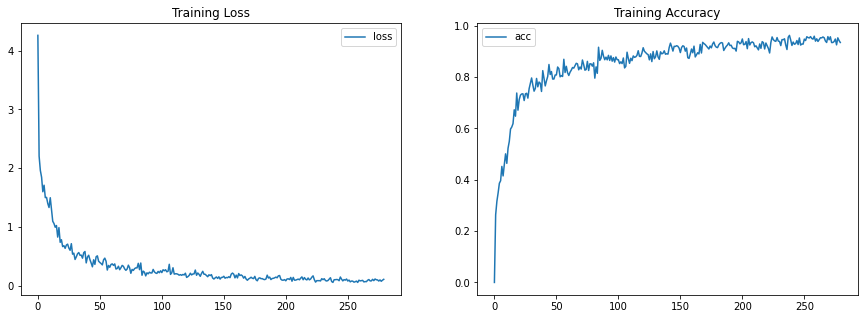

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [67]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/machine-translation/models/fra-eng/training_ckpt_seq2seq_att'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [68]:
predicted_list = []

In [69]:
def predict_seq2seq_att(input_text, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
    #print(input_text)
    # Tokenize the input text
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # Get the encoder initial states
    en_initial_states = encoder.init_states(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    alignments = []

    while True:
        # Get the decoder with attention output
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break
    # Join the output words
    #print(' '.join(out_words))
    out_words = ' '.join(out_words)
    predicted_list.append(out_words)
    #print('Predicted English Text - ',out_words)
    return np.array(alignments), input_text.split(' '), out_words, predicted_list

In [70]:
# Preprocess the input data
input_data_test = test[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data_test = test[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is right shifted
target_input_data_test = test[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()
print(input_data_test[:10])
print(target_data_test[:10])
print(target_input_data_test[:10])

['elle a suggere que je l emmene au zoo .', 'vous etes assez mignonne quand vous etes en colere .', 'laisse moi emprunter ca .', 'je pense que ce serait mieux que tu ne fasses pas cela .', 'n y pense meme pas !', 'je veux rester un peu plus longtemps .', 'je crains que nous ne soyons pas en mesure de t aider demain .', 'je commence a comprendre .', 'qu est ce qu elles se chuchotent ?', 'je ne peux pas finir ceci avant demain .']
['she suggested that i take him to the zoo . <eos>', 'you re kind of cute when you re mad . <eos>', 'let me borrow that . <eos>', 'i think it d be better if you didn t do that . <eos>', 'don t even think about it . <eos>', 'i want to stay a bit longer . <eos>', 'i m afraid we won t be able to help you tomorrow . <eos>', 'i am beginning to understand . <eos>', 'what are they whispering to each other ? <eos>', 'i can t finish this by tomorrow . <eos>']
['<sos> she suggested that i take him to the zoo .', '<sos> you re kind of cute when you re mad .', '<sos> let m

In [72]:
print(len(input_data_test))
print(len(target_data_test))
print(len(target_input_data_test))

1797
1797
1797


In [73]:
for test_sent, test_output in zip(input_data_test, target_data_test):
    predict_seq2seq_att(test_sent, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)

In [74]:
predicted_list

['she suggested that i take him to the zoo . <eos>',
 'you re kind of cute when you re mad . <eos>',
 'let me borrow this . <eos>',
 'i think you d better be better . <eos>',
 'don t do even about it . <eos>',
 'i want to stay a little longer . <eos>',
 'i m afraid we won t be able to help you tomorrow . <eos>',
 'i m beginning to understand . <eos>',
 'what are they whispering to each other ? <eos>',
 'i can t finish this before tomorrow . <eos>',
 'excuse me , is the accountant ? <eos>',
 'do i see what i m thinking ? <eos>',
 'who built it ? <eos>',
 'tom was just one leg . <eos>',
 'we need action . <eos>',
 'he gives me a bad liar . <eos>',
 'unfortunately , that wasn t possible . <eos>',
 'you re photogenic . <eos>',
 'aren t you too young for smoking ? <eos>',
 'i don t want to throw that . <eos>',
 'you ll get used to it one day . <eos>',
 'i was bitten by mosquitoes on everybody . <eos>',
 'take in touch with me as soon as you arrive here . <eos>',
 'can you give me another pi

In [75]:
predicted_list[:10]

['she suggested that i take him to the zoo . <eos>',
 'you re kind of cute when you re mad . <eos>',
 'let me borrow this . <eos>',
 'i think you d better be better . <eos>',
 'don t do even about it . <eos>',
 'i want to stay a little longer . <eos>',
 'i m afraid we won t be able to help you tomorrow . <eos>',
 'i m beginning to understand . <eos>',
 'what are they whispering to each other ? <eos>',
 'i can t finish this before tomorrow . <eos>']

In [76]:
target_data_test[:10]

['she suggested that i take him to the zoo . <eos>',
 'you re kind of cute when you re mad . <eos>',
 'let me borrow that . <eos>',
 'i think it d be better if you didn t do that . <eos>',
 'don t even think about it . <eos>',
 'i want to stay a bit longer . <eos>',
 'i m afraid we won t be able to help you tomorrow . <eos>',
 'i am beginning to understand . <eos>',
 'what are they whispering to each other ? <eos>',
 'i can t finish this by tomorrow . <eos>']

In [77]:
#BLEU SCORE using our own function
#Bleu = Brevity Penalty * precision
def brevity_penalty(reference, candidate):
    ref_length = len(reference)
    can_length = len(candidate)

    # Brevity Penalty
    if ref_length > can_length:
        BP = 1
    else:
        penalty = 1 - (ref_length / can_length)
        BP = np.exp(penalty)

    return BP

In [78]:
def clipped_precision(reference, candidate):
    """
    Bleu score function given a original and a machine translated sentences
    """

    clipped_precision_score = []

    for i in range(1, 5):
        candidate_n_gram = Counter(
            ngrams(candidate, i)
        )  # counts of n-gram n=1...4 tokens for the candidate
        reference_n_gram = Counter(
            ngrams(reference, i)
        )  # counts of n-gram n=1...4 tokens for the reference

        c = sum(
            reference_n_gram.values()
        )  # sum of the values of the reference the denominator in the precision formula

        for j in reference_n_gram:  # for every n_gram token in the reference
            if j in candidate_n_gram:  # check if it is in the candidate n-gram

                if (
                    reference_n_gram[j] > candidate_n_gram[j]
                ):  # if the count of the reference n-gram is bigger
                    # than the corresponding count in the candidate n-gram
                    reference_n_gram[j] = candidate_n_gram[
                        j
                    ]  # then set the count of the reference n-gram to be equal
                    # to the count of the candidate n-gram
            else:

                reference_n_gram[j] = 0  # else reference n-gram = 0

        clipped_precision_score.append(sum(reference_n_gram.values()) / c)

    weights = [0.25] * 4

    s = (w_i * np.log(p_i) for w_i, p_i in zip(weights, clipped_precision_score))
    s = np.exp(np.sum(s))
    return s

In [79]:
def bleu_score(reference, candidate):
    BP = brevity_penalty(reference, candidate)
    precision = clipped_precision(reference, candidate)
    return BP * precision

In [80]:
#Word Tokenizing every element in the reference and candidate list
bleu = []
for tokenized_ref, tokenized_can in zip(target_data_test[:10000], predicted_list): 
    score = round(bleu_score(tokenized_ref, tokenized_can) * 100, 1)
    bleu.append(score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


In [81]:
statistics.mean(bleu)

84.51313299944351

In [82]:
#SacreBleu Score
#Word Tokenizing every element in the reference and candidate list
bleu_score = []
for tokenized_ref, tokenized_can in zip(target_data_test, predicted_list): 
    score = round(sacrebleu.corpus_bleu(tokenized_ref, tokenized_can).score, 1)
    bleu_score.append(score)

In [83]:
statistics.mean(bleu_score)

71.0180856983862

In [84]:
#Not sure if correct. might have some error
from nltk.translate.bleu_score import sentence_bleu
nltk_bleu_score = []
for tokenized_ref, tokenized_can in zip(target_data_test, predicted_list): 
    score = sentence_bleu(tokenized_ref, tokenized_can)
    nltk_bleu_score.append(score)

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [86]:
statistics.mean(nltk_bleu_score)*100

82.86886648072779